In [1]:
import sys
import os, logging
import csv

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
import tensorflow as tf
import sys
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
LETTERS = 'abcdefghijklmnopqrstuwxyz'
NUMBERS = '0123456789'
SPEC_CHARS = ['+','\"','*','#','%','&','(',')','=','?','^','-','.','!','~','_','>','<']

def check_url_contains_words(url):
    found_words = []
    for letter in LETTERS:
        dictionary = open('dictionary/wb1913_{}.txt'.format(letter), 'rb')
        for line in dictionary.readlines():
            line = str(line)
            word = line.split('</B>')[0].replace('<P><B>', '').lower()
            if str(word) in url.lower() and len(word) > 1 and word not in found_words:
                found_words.append(word)
    return len(found_words)



In [ ]:
enriched_csv = open('url_enriched_data.csv', 'w')
enriched_csv.write('len,spec_chars,domain,depth,numericals_count,word_count,label\n')

This data is not usable in it’s current state, we need to enrich it by generating the following new features:
- Length: length of the URL
- Depth: the occurrence of ‘/’ character in the URL
- Numerical count: count of numeric characters
- Words count: count of English words present in the URL
- Special chars count: count of specials characters

In [ ]:
count = 0

for row in  csv.reader(open('url_data.csv', 'r'), delimiter = ','):
    spec_chars, depth, numericals_count, word_count = 0, 0, 0, 0
    
    
    if 'bad' in row[1].lower():
        label = '1'
    else:
        label = '0'

    url = str(row[0])
    # print(count, url, label)
    
    count += 1
    
    word_count = check_url_contains_words(url)
    
    for c in str(row[0]):
        if c in SPEC_CHARS:
            spec_chars += 1
        if c in ['/']:
            depth += 1
        if c in NUMBERS:
            numericals_count += 1
    enriched_csv.write(str(len(row[0])) + ',' + str(spec_chars) + ',0,' + str(depth) + ',' + str(numericals_count) + ',' + str(word_count) + ',' + label + '\n')

Load the new dataset with engineered features.

In [2]:
df = pd.read_csv("enriched_url_data.csv")

# Dimension of the dataset
print(df.shape)

(420465, 7)


Check for any null values

In [3]:
# Missing values
print(df.isnull().values.any())

False


Create two separate lists of URLs

In [4]:
frauds = df[df.label == 1]
normal = df[df.label == 0]

print(frauds.shape)

(75643, 7)


While creating the enriched data, we had given domain feature a constant value. Lets drop that column since it has no information.

In [5]:
data = df.drop(['domain'], axis=1) # since no useful value is stored there 
print(data.shape)

(420465, 6)


Split the datasets, and drop the label column from the training data.

In [6]:
X_train, X_test = train_test_split(data, test_size=0.2)

# Take only the normal cases
X_train = X_train[X_train.label == 0]
X_train = X_train.drop(['label'], axis=1)

y_test = X_test['label']
X_test = X_test.drop(['label'], axis=1)
X_train = X_train.values
X_test = X_test.values


Select the size of the encoding/input layer. 

In [7]:
input_dim = X_train.shape[1]
encoding_dim = input_dim

Build the sequential autoencoder model.

In [9]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(int(encoding_dim-1), activation="relu")(encoder)

encoder = Dense(int(encoding_dim-2), activation="relu")(encoder)

code = Dense(int(encoding_dim-3), activation='tanh')(encoder)

decoder = Dense(int(encoding_dim-2), activation='tanh')(code)

decoder = Dense(int(encoding_dim-1), activation='tanh')(encoder)

decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 16        
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 25        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


Set the parameters, callbacks and train the model. 

In [10]:
nb_epoch = 100
batch_size = 60

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

W0826 14:02:23.238349 140657874102016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 14:02:23.800320 140657874102016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:976: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0826 14:02:23.922747 140657874102016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:963: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 275832 samples, validate on 84093 samples


W0826 14:02:24.829104 140657874102016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:774: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0826 14:02:24.830492 140657874102016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/callbacks.py:777: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
275832/275832 [==============================] - 11s 41us/step - loss: 452.9474 - acc: 0.6147 - val_loss: 412.1477 - val_acc: 0.9991

Epoch 00001: val_loss improved from inf to 412.14775, saving model to model.h5
Epoch 2/100
275832/275832 [==============================] - 11s 38us/step - loss: 200.9940 - acc: 0.9991 - val_loss: 251.2038 - val_acc: 0.9991

Epoch 00002: val_loss improved from 412.14775 to 251.20385, saving model to model.h5
Epoch 3/100
275832/275832 [==============================] - 11s 39us/step - loss: 98.4852 - acc: 0.9991 - val_loss: 173.2247 - val_acc: 0.9991

Epoch 00003: val_loss improved from 251.20385 to 173.22474, saving model to model.h5
Epoch 4/100
275832/275832 [==============================] - 11s 39us/step - loss: 53.7703 - acc: 0.9991 - val_loss: 133.9582 - val_acc: 0.9991

Epoch 00004: val_loss improved from 173.22474 to 133.95822, saving model to model.h5
Epoch 5/100
275832/275832 [==============================] - 11s 39us/step - loss: 3

275832/275832 [==============================] - 10s 37us/step - loss: 13.1902 - acc: 0.9991 - val_loss: 53.6493 - val_acc: 0.9991

Epoch 00037: val_loss improved from 53.96310 to 53.64929, saving model to model.h5
Epoch 38/100
275832/275832 [==============================] - 10s 37us/step - loss: 13.1368 - acc: 0.9991 - val_loss: 53.3301 - val_acc: 0.9991

Epoch 00038: val_loss improved from 53.64929 to 53.33005, saving model to model.h5
Epoch 39/100
275832/275832 [==============================] - 10s 36us/step - loss: 13.2039 - acc: 0.9991 - val_loss: 53.0275 - val_acc: 0.9991

Epoch 00039: val_loss improved from 53.33005 to 53.02754, saving model to model.h5
Epoch 40/100
275832/275832 [==============================] - 10s 36us/step - loss: 13.0802 - acc: 0.9991 - val_loss: 52.9269 - val_acc: 0.9991

Epoch 00040: val_loss improved from 53.02754 to 52.92685, saving model to model.h5
Epoch 41/100
275832/275832 [==============================] - 10s 36us/step - loss: 13.0486 - acc: 0.

275832/275832 [==============================] - 10s 35us/step - loss: 12.8421 - acc: 0.9991 - val_loss: 47.1069 - val_acc: 0.9991

Epoch 00074: val_loss improved from 47.13555 to 47.10693, saving model to model.h5
Epoch 75/100
275832/275832 [==============================] - 10s 35us/step - loss: 12.8362 - acc: 0.9991 - val_loss: 47.5272 - val_acc: 0.9991

Epoch 00075: val_loss did not improve
Epoch 76/100
275832/275832 [==============================] - 10s 35us/step - loss: 12.7574 - acc: 0.9991 - val_loss: 46.8281 - val_acc: 0.9991

Epoch 00076: val_loss improved from 47.10693 to 46.82814, saving model to model.h5
Epoch 77/100
275832/275832 [==============================] - 10s 35us/step - loss: 12.7309 - acc: 0.9991 - val_loss: 46.6940 - val_acc: 0.9991

Epoch 00077: val_loss improved from 46.82814 to 46.69396, saving model to model.h5
Epoch 78/100
275832/275832 [==============================] - 10s 35us/step - loss: 12.7976 - acc: 0.9991 - val_loss: 46.7739 - val_acc: 0.9991

E

Load from the saved model.

In [11]:
autoencoder = load_model('model.h5')

Make predictions on the test data

In [12]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
fraud_error_df = error_df[error_df['true_class'] == 1]

Calibrate the threshold value

In [18]:
threshold=0
f1=0
recall=0
accuracy=0

# threshold = 1.6674999999998719

while (recall < 0.5 or accuracy < 0.6):
    

    threshold += .005
    y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    
    conf_matrix = confusion_matrix(error_df.true_class, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    
    precision = 1. * tp / (tp + fp)
    recall = 1. * tp / (tp + fn)
    f1 = (2 * recall * precision) / (recall + precision)
    accuracy = 1. * (tp + tn) / (tp + tn + fp + fn)
    
    print('\nThreshold: {}  ::  Recall: {}  ::  Accuracy: {}  '.format(threshold, 
                                                                      recall, accuracy))


Threshold: 0.005  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.01  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.015  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.02  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.025  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.030000000000000002  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.035  ::  Recall: 1.0  ::  Accuracy: 0.1795987775439097  

Threshold: 0.04  ::  Recall: 0.9999337879891412  ::  Accuracy: 0.17986039266050682  

Threshold: 0.045  ::  Recall: 0.9999337879891412  ::  Accuracy: 0.17986039266050682  

Threshold: 0.049999999999999996  ::  Recall: 0.9998013639674237  ::  Accuracy: 0.18045497247095477  

Threshold: 0.05499999999999999  ::  Recall: 0.9993378798914123  ::  Accuracy: 0.18096631110794  

Threshold: 0.05999999999999999  ::  Recall: 0.9993378798914123  ::  Accuracy: 0.18099009430035792  

Threshold: 0.06


Threshold: 0.4400000000000003  ::  Recall: 0.9686817188638019  ::  Accuracy: 0.20664026732308277  

Threshold: 0.4450000000000003  ::  Recall: 0.9672912666357677  ::  Accuracy: 0.20742511267287408  

Threshold: 0.4500000000000003  ::  Recall: 0.9668939945706151  ::  Accuracy: 0.2077937521553518  

Threshold: 0.4550000000000003  ::  Recall: 0.9667615705488976  ::  Accuracy: 0.2078769933288145  

Threshold: 0.4600000000000003  ::  Recall: 0.9658346023968748  ::  Accuracy: 0.20810293365678476  

Threshold: 0.4650000000000003  ::  Recall: 0.9654373303317222  ::  Accuracy: 0.2081980664264564  

Threshold: 0.4700000000000003  ::  Recall: 0.9647752102231345  ::  Accuracy: 0.20820995802266537  

Threshold: 0.4750000000000003  ::  Recall: 0.9639144540819705  ::  Accuracy: 0.20864994708239687  

Threshold: 0.4800000000000003  ::  Recall: 0.9629212739190889  ::  Accuracy: 0.20888777900657604  

Threshold: 0.4850000000000003  ::  Recall: 0.9622591538105012  ::  Accuracy: 0.20929209327768067  

Th


Threshold: 0.8600000000000007  ::  Recall: 0.9194199827848771  ::  Accuracy: 0.23908054178112328  

Threshold: 0.8650000000000007  ::  Recall: 0.9191551347414421  ::  Accuracy: 0.23941350647497414  

Threshold: 0.8700000000000007  ::  Recall: 0.9181619545785605  ::  Accuracy: 0.2404718585375715  

Threshold: 0.8750000000000007  ::  Recall: 0.9173011984373965  ::  Accuracy: 0.24135183665703447  

Threshold: 0.8800000000000007  ::  Recall: 0.9168377143613852  ::  Accuracy: 0.2424815382968856  

Threshold: 0.8850000000000007  ::  Recall: 0.9162418062636563  ::  Accuracy: 0.24281450299073645  

Threshold: 0.8900000000000007  ::  Recall: 0.9159107462093624  ::  Accuracy: 0.24318314247321418  

Threshold: 0.8950000000000007  ::  Recall: 0.914851354035622  ::  Accuracy: 0.24356367355190087  

Threshold: 0.9000000000000007  ::  Recall: 0.9145865059921869  ::  Accuracy: 0.24389663824575172  

Threshold: 0.9050000000000007  ::  Recall: 0.9143216579487519  ::  Accuracy: 0.24415825336234884  

Th


Threshold: 1.2799999999999947  ::  Recall: 0.8713500629014103  ::  Accuracy: 0.27424399177101544  

Threshold: 1.2849999999999946  ::  Recall: 0.8708865788253989  ::  Accuracy: 0.274362907733105  

Threshold: 1.2899999999999945  ::  Recall: 0.87029067072767  ::  Accuracy: 0.2747672220042096  

Threshold: 1.2949999999999944  ::  Recall: 0.8699596106733761  ::  Accuracy: 0.2749218127549261  

Threshold: 1.2999999999999943  ::  Recall: 0.8694961265973647  ::  Accuracy: 0.2753261270260307  

Threshold: 1.3049999999999942  ::  Recall: 0.868569158445342  ::  Accuracy: 0.2759088152402697  

Threshold: 1.309999999999994  ::  Recall: 0.8684367344236245  ::  Accuracy: 0.2766698773976431  

Threshold: 1.314999999999994  ::  Recall: 0.8671787062173079  ::  Accuracy: 0.2770147336877029  

Threshold: 1.3199999999999938  ::  Recall: 0.866582798119579  ::  Accuracy: 0.27810876053892714  

Threshold: 1.3249999999999937  ::  Recall: 0.8659868900218499  ::  Accuracy: 0.27847740002140486  

Threshold: 1.


Threshold: 1.6999999999999857  ::  Recall: 0.8248692312785539  ::  Accuracy: 0.3054356486271152  

Threshold: 1.7049999999999856  ::  Recall: 0.8248030192676952  ::  Accuracy: 0.3057329385323392  

Threshold: 1.7099999999999855  ::  Recall: 0.8245381712242601  ::  Accuracy: 0.30622049397690654  

Threshold: 1.7149999999999854  ::  Recall: 0.8238098391048136  ::  Accuracy: 0.3065177838821305  

Threshold: 1.7199999999999853  ::  Recall: 0.823147718996226  ::  Accuracy: 0.3071004720963695  

Threshold: 1.7249999999999852  ::  Recall: 0.8229490829636497  ::  Accuracy: 0.30735019561675764  

Threshold: 1.729999999999985  ::  Recall: 0.8227504469310732  ::  Accuracy: 0.3078853174461608  

Threshold: 1.734999999999985  ::  Recall: 0.8222869628550619  ::  Accuracy: 0.30871772918078794  

Threshold: 1.739999999999985  ::  Recall: 0.8214924187247566  ::  Accuracy: 0.3093955501646986  

Threshold: 1.7449999999999848  ::  Recall: 0.8213599947030391  ::  Accuracy: 0.30952635772299714  

Threshold


Threshold: 2.119999999999977  ::  Recall: 0.779116731775144  ::  Accuracy: 0.3344749265693934  

Threshold: 2.124999999999977  ::  Recall: 0.7786532476991326  ::  Accuracy: 0.33471275849357257  

Threshold: 2.129999999999977  ::  Recall: 0.7783883996556975  ::  Accuracy: 0.3349624820139607  

Threshold: 2.1349999999999767  ::  Recall: 0.7783221876448387  ::  Accuracy: 0.33539057947748324  

Threshold: 2.1399999999999766  ::  Recall: 0.7779249155796861  ::  Accuracy: 0.3356165198054535  

Threshold: 2.1449999999999765  ::  Recall: 0.7777924915579686  ::  Accuracy: 0.3357948937485879  

Threshold: 2.1499999999999764  ::  Recall: 0.7771965834602397  ::  Accuracy: 0.33583056853721477  

Threshold: 2.1549999999999763  ::  Recall: 0.7768655234059458  ::  Accuracy: 0.33608029205760287  

Threshold: 2.159999999999976  ::  Recall: 0.7767330993842283  ::  Accuracy: 0.33640136515524477  

Threshold: 2.164999999999976  ::  Recall: 0.7767330993842283  ::  Accuracy: 0.3365678475021702  

Threshold:


Threshold: 2.539999999999968  ::  Recall: 0.7438919419982785  ::  Accuracy: 0.36410878432211957  

Threshold: 2.544999999999968  ::  Recall: 0.7434284579222671  ::  Accuracy: 0.36444174901597043  

Threshold: 2.549999999999968  ::  Recall: 0.7430311858571145  ::  Accuracy: 0.36478660530603024  

Threshold: 2.5549999999999677  ::  Recall: 0.7426339137919619  ::  Accuracy: 0.3649055212681198  

Threshold: 2.5599999999999676  ::  Recall: 0.7421042177050917  ::  Accuracy: 0.36497687084537356  

Threshold: 2.5649999999999675  ::  Recall: 0.7415745216182216  ::  Accuracy: 0.365143353192299  

Threshold: 2.5699999999999674  ::  Recall: 0.7413758855856453  ::  Accuracy: 0.36533361873164233  

Threshold: 2.5749999999999673  ::  Recall: 0.7410448255313514  ::  Accuracy: 0.365726041406538  

Threshold: 2.579999999999967  ::  Recall: 0.7407799774879164  ::  Accuracy: 0.3661065724852247  

Threshold: 2.584999999999967  ::  Recall: 0.740316493411905  ::  Accuracy: 0.3664276455828666  

Threshold: 2


Threshold: 2.959999999999959  ::  Recall: 0.7093292723300006  ::  Accuracy: 0.3879276515286647  

Threshold: 2.964999999999959  ::  Recall: 0.708667152221413  ::  Accuracy: 0.3882249414338887  

Threshold: 2.969999999999959  ::  Recall: 0.7080050321128253  ::  Accuracy: 0.3883557489921872  

Threshold: 2.974999999999959  ::  Recall: 0.7079388201019665  ::  Accuracy: 0.3886292557049933  

Threshold: 2.9799999999999587  ::  Recall: 0.7073429120042376  ::  Accuracy: 0.3899373312879788  

Threshold: 2.9849999999999586  ::  Recall: 0.7070118519499438  ::  Accuracy: 0.3901394884235311  

Threshold: 2.9899999999999585  ::  Recall: 0.7064159438522148  ::  Accuracy: 0.3903773203477103  

Threshold: 2.9949999999999584  ::  Recall: 0.7062835198304972  ::  Accuracy: 0.39067461025293426  

Threshold: 2.9999999999999583  ::  Recall: 0.7055551877110507  ::  Accuracy: 0.39091244217711346  

Threshold: 3.004999999999958  ::  Recall: 0.7052241276567569  ::  Accuracy: 0.3911859488899195  

Threshold: 3.


Threshold: 3.37999999999995  ::  Recall: 0.6764881149440508  ::  Accuracy: 0.41293567835610573  

Threshold: 3.38499999999995  ::  Recall: 0.6760246308680394  ::  Accuracy: 0.4130902691068222  

Threshold: 3.38999999999995  ::  Recall: 0.6753625107594518  ::  Accuracy: 0.41330431783858346  

Threshold: 3.39499999999995  ::  Recall: 0.6749652386942991  ::  Accuracy: 0.41366106572485223  

Threshold: 3.3999999999999497  ::  Recall: 0.6748328146725816  ::  Accuracy: 0.4138988976490314  

Threshold: 3.4049999999999496  ::  Recall: 0.6747666026617228  ::  Accuracy: 0.41405348839974787  

Threshold: 3.4099999999999495  ::  Recall: 0.6746341786400053  ::  Accuracy: 0.414303211920136  

Threshold: 3.4149999999999494  ::  Recall: 0.6746341786400053  ::  Accuracy: 0.41448158586327044  

Threshold: 3.4199999999999493  ::  Recall: 0.6745017546182878  ::  Accuracy: 0.4147194177874496  

Threshold: 3.424999999999949  ::  Recall: 0.6743031185857115  ::  Accuracy: 0.4148740085381661  

Threshold: 3.4


Threshold: 3.799999999999941  ::  Recall: 0.6515261868502946  ::  Accuracy: 0.43658806321572546  

Threshold: 3.804999999999941  ::  Recall: 0.6513275508177183  ::  Accuracy: 0.4369329195057853  

Threshold: 3.809999999999941  ::  Recall: 0.6509964907634245  ::  Accuracy: 0.43769398166315865  

Threshold: 3.814999999999941  ::  Recall: 0.6507316427199894  ::  Accuracy: 0.43786046401008405  

Threshold: 3.8199999999999408  ::  Recall: 0.6504005826656956  ::  Accuracy: 0.43815775391530803  

Threshold: 3.8249999999999407  ::  Recall: 0.650268158643978  ::  Accuracy: 0.4383718026470693  

Threshold: 3.8299999999999406  ::  Recall: 0.6501357346222605  ::  Accuracy: 0.4385501765902037  

Threshold: 3.8349999999999405  ::  Recall: 0.650003310600543  ::  Accuracy: 0.4387761169181739  

Threshold: 3.8399999999999403  ::  Recall: 0.6495398265245316  ::  Accuracy: 0.4389663824575173  

Threshold: 3.8449999999999402  ::  Recall: 0.649407402502814  ::  Accuracy: 0.4391328648044427  

Threshold: 3


Threshold: 4.219999999999932  ::  Recall: 0.6263656227239621  ::  Accuracy: 0.4558881238628661  

Threshold: 4.224999999999932  ::  Recall: 0.6262331987022446  ::  Accuracy: 0.45605460620979155  

Threshold: 4.229999999999932  ::  Recall: 0.6260345626696683  ::  Accuracy: 0.4561497389794632  

Threshold: 4.234999999999932  ::  Recall: 0.625835926637092  ::  Accuracy: 0.4563043297301797  

Threshold: 4.239999999999932  ::  Recall: 0.6253062305502218  ::  Accuracy: 0.45688701794441866  

Threshold: 4.244999999999932  ::  Recall: 0.6251075945176455  ::  Accuracy: 0.45718430784964265  

Threshold: 4.249999999999932  ::  Recall: 0.6247103224524929  ::  Accuracy: 0.45724376583068743  

Threshold: 4.2549999999999315  ::  Recall: 0.6246441104416341  ::  Accuracy: 0.4573032238117323  

Threshold: 4.259999999999931  ::  Recall: 0.6243130503873403  ::  Accuracy: 0.4574102481776129  

Threshold: 4.264999999999931  ::  Recall: 0.6242468383764815  ::  Accuracy: 0.4576480801017921  

Threshold: 4.26


Threshold: 4.639999999999923  ::  Recall: 0.6041183870754154  ::  Accuracy: 0.47566384835836517  

Threshold: 4.644999999999923  ::  Recall: 0.6040521750645567  ::  Accuracy: 0.4763535609384848  

Threshold: 4.649999999999923  ::  Recall: 0.6038535390319804  ::  Accuracy: 0.4765438264778281  

Threshold: 4.654999999999923  ::  Recall: 0.6037211150102628  ::  Accuracy: 0.47667463403612664  

Threshold: 4.659999999999923  ::  Recall: 0.6035886909885453  ::  Accuracy: 0.4767816584020073  

Threshold: 4.664999999999923  ::  Recall: 0.6035886909885453  ::  Accuracy: 0.47697192394135063  

Threshold: 4.669999999999923  ::  Recall: 0.6033238429451102  ::  Accuracy: 0.47725732225036566  

Threshold: 4.6749999999999226  ::  Recall: 0.6031252069125339  ::  Accuracy: 0.4776497449252613  

Threshold: 4.6799999999999224  ::  Recall: 0.6026617228365225  ::  Accuracy: 0.47770920290630614  

Threshold: 4.684999999999922  ::  Recall: 0.6021320267496524  ::  Accuracy: 0.47784001046460467  

Threshold: 


Threshold: 5.059999999999914  ::  Recall: 0.5839899357743494  ::  Accuracy: 0.49241910741678857  

Threshold: 5.064999999999914  ::  Recall: 0.5837250877309144  ::  Accuracy: 0.49250234859025127  

Threshold: 5.069999999999914  ::  Recall: 0.5834602396874793  ::  Accuracy: 0.4927045057258036  

Threshold: 5.074999999999914  ::  Recall: 0.5833278156657618  ::  Accuracy: 0.4928472048803111  

Threshold: 5.079999999999914  ::  Recall: 0.5829305436006091  ::  Accuracy: 0.4930255788234455  

Threshold: 5.084999999999914  ::  Recall: 0.5826656955571741  ::  Accuracy: 0.4931326031893261  

Threshold: 5.089999999999914  ::  Recall: 0.5825994835463153  ::  Accuracy: 0.49318016957416194  

Threshold: 5.094999999999914  ::  Recall: 0.5820697874594452  ::  Accuracy: 0.49360826703768446  

Threshold: 5.0999999999999135  ::  Recall: 0.5820035754485864  ::  Accuracy: 0.49386988215428157  

Threshold: 5.104999999999913  ::  Recall: 0.5818711514268688  ::  Accuracy: 0.49395312332774427  

Threshold: 5


Threshold: 5.489999999999905  ::  Recall: 0.5635966364298484  ::  Accuracy: 0.5116597100828845  

Threshold: 5.494999999999905  ::  Recall: 0.5635304244189896  ::  Accuracy: 0.511790517641183  

Threshold: 5.499999999999905  ::  Recall: 0.5630007283321194  ::  Accuracy: 0.5119451083918994  

Threshold: 5.504999999999905  ::  Recall: 0.5626696682778256  ::  Accuracy: 0.51205213275778  

Threshold: 5.509999999999905  ::  Recall: 0.5626034562669668  ::  Accuracy: 0.5122899646819593  

Threshold: 5.514999999999905  ::  Recall: 0.5623386082235318  ::  Accuracy: 0.5124683386250937  

Threshold: 5.5199999999999045  ::  Recall: 0.562272396212673  ::  Accuracy: 0.5126348209720191  

Threshold: 5.524999999999904  ::  Recall: 0.5620075481692379  ::  Accuracy: 0.5129083276848251  

Threshold: 5.529999999999904  ::  Recall: 0.5617427001258029  ::  Accuracy: 0.5131223764165864  

Threshold: 5.534999999999904  ::  Recall: 0.5614778520823678  ::  Accuracy: 0.5134196663218104  

Threshold: 5.539999999


Threshold: 5.909999999999896  ::  Recall: 0.5453221214328279  ::  Accuracy: 0.5283911859488899  

Threshold: 5.914999999999896  ::  Recall: 0.5448586373568165  ::  Accuracy: 0.5286052346806512  

Threshold: 5.919999999999896  ::  Recall: 0.5447924253459577  ::  Accuracy: 0.5287003674503229  

Threshold: 5.924999999999896  ::  Recall: 0.544726213335099  ::  Accuracy: 0.528938199374502  

Threshold: 5.929999999999896  ::  Recall: 0.5445937893133814  ::  Accuracy: 0.5290452237403827  

Threshold: 5.934999999999896  ::  Recall: 0.5442627292590876  ::  Accuracy: 0.5291641397024722  

Threshold: 5.939999999999896  ::  Recall: 0.5440640932265113  ::  Accuracy: 0.529211706087308  

Threshold: 5.9449999999998955  ::  Recall: 0.5437992451830762  ::  Accuracy: 0.5293187304531888  

Threshold: 5.949999999999895  ::  Recall: 0.5436006091504999  ::  Accuracy: 0.5293544052418157  

Threshold: 5.954999999999895  ::  Recall: 0.5434019731179236  ::  Accuracy: 0.5294376464152784  

Threshold: 5.95999999


Threshold: 6.329999999999887  ::  Recall: 0.5273124544792426  ::  Accuracy: 0.5432437896138799  

Threshold: 6.334999999999887  ::  Recall: 0.5273124544792426  ::  Accuracy: 0.5433864887683874  

Threshold: 6.339999999999887  ::  Recall: 0.5272462424683838  ::  Accuracy: 0.5435886459039397  

Threshold: 6.344999999999887  ::  Recall: 0.5270476064358075  ::  Accuracy: 0.5436481038849845  

Threshold: 6.349999999999887  ::  Recall: 0.5268489704032312  ::  Accuracy: 0.5437670198470741  

Threshold: 6.354999999999887  ::  Recall: 0.5267827583923724  ::  Accuracy: 0.5440524181560891  

Threshold: 6.359999999999887  ::  Recall: 0.5266503343706548  ::  Accuracy: 0.5444686240234027  

Threshold: 6.3649999999998865  ::  Recall: 0.526584122359796  ::  Accuracy: 0.5445756483892833  

Threshold: 6.369999999999886  ::  Recall: 0.526584122359796  ::  Accuracy: 0.5446826727551639  

Threshold: 6.374999999999886  ::  Recall: 0.5263854863272197  ::  Accuracy: 0.5448134803134624  

Threshold: 6.3799999


Threshold: 6.749999999999878  ::  Recall: 0.5075812752433292  ::  Accuracy: 0.5554445673242719  

Threshold: 6.754999999999878  ::  Recall: 0.5073164271998941  ::  Accuracy: 0.5554921337091078  

Threshold: 6.759999999999878  ::  Recall: 0.5071840031781765  ::  Accuracy: 0.5555991580749884  

Threshold: 6.764999999999878  ::  Recall: 0.5071840031781765  ::  Accuracy: 0.5556823992484511  

Threshold: 6.769999999999878  ::  Recall: 0.5071840031781765  ::  Accuracy: 0.5557775320181227  

Threshold: 6.774999999999878  ::  Recall: 0.5071177911673177  ::  Accuracy: 0.5558607731915856  

Threshold: 6.779999999999878  ::  Recall: 0.5069191551347414  ::  Accuracy: 0.5558726647877945  

Threshold: 6.784999999999878  ::  Recall: 0.5067867311130239  ::  Accuracy: 0.556003472346093  

Threshold: 6.7899999999998775  ::  Recall: 0.5065218830695888  ::  Accuracy: 0.5560629303271378  

Threshold: 6.794999999999877  ::  Recall: 0.5063894590478712  ::  Accuracy: 0.5561937378854364  

Threshold: 6.799999


Threshold: 7.169999999999869  ::  Recall: 0.4901675163874727  ::  Accuracy: 0.5678118273815894  

Threshold: 7.174999999999869  ::  Recall: 0.49003509236575515  ::  Accuracy: 0.5678831769588432  

Threshold: 7.179999999999869  ::  Recall: 0.48983645633317885  ::  Accuracy: 0.5681210088830224  

Threshold: 7.184999999999869  ::  Recall: 0.4897040323114613  ::  Accuracy: 0.5683112744223657  

Threshold: 7.189999999999869  ::  Recall: 0.48943918426802624  ::  Accuracy: 0.5683945155958284  

Threshold: 7.194999999999869  ::  Recall: 0.4891081242137324  ::  Accuracy: 0.5685609979427538  

Threshold: 7.199999999999869  ::  Recall: 0.4889757001920148  ::  Accuracy: 0.5687155886934703  

Threshold: 7.204999999999869  ::  Recall: 0.48884327617029727  ::  Accuracy: 0.5687988298669331  

Threshold: 7.2099999999998685  ::  Recall: 0.48871085214857973  ::  Accuracy: 0.5689177458290227  

Threshold: 7.214999999999868  ::  Recall: 0.4885784281268622  ::  Accuracy: 0.5690128785986943  

Threshold: 7.


Threshold: 7.58999999999986  ::  Recall: 0.476262994107131  ::  Accuracy: 0.5822957915641016  

Threshold: 7.59499999999986  ::  Recall: 0.4760643580745547  ::  Accuracy: 0.5823314663527285  

Threshold: 7.59999999999986  ::  Recall: 0.47599814606369595  ::  Accuracy: 0.5823790327375644  

Threshold: 7.60499999999986  ::  Recall: 0.4757332980202609  ::  Accuracy: 0.5824028159299823  

Threshold: 7.60999999999986  ::  Recall: 0.4754684499768258  ::  Accuracy: 0.5827476722200421  

Threshold: 7.61499999999986  ::  Recall: 0.47533602595510827  ::  Accuracy: 0.5828428049897137  

Threshold: 7.61999999999986  ::  Recall: 0.47520360193339073  ::  Accuracy: 0.5829736125480123  

Threshold: 7.62499999999986  ::  Recall: 0.4750711779116732  ::  Accuracy: 0.583068745317684  

Threshold: 7.62999999999986  ::  Recall: 0.47493875388995566  ::  Accuracy: 0.5836989999167588  

Threshold: 7.6349999999998595  ::  Recall: 0.4748063298682381  ::  Accuracy: 0.5842816881309978  

Threshold: 7.639999999999


Threshold: 8.009999999999852  ::  Recall: 0.46268953188108325  ::  Accuracy: 0.5931290357104634  

Threshold: 8.014999999999853  ::  Recall: 0.46268953188108325  ::  Accuracy: 0.593236060076344  

Threshold: 8.019999999999854  ::  Recall: 0.4622922598159306  ::  Accuracy: 0.5932122768839261  

Threshold: 8.024999999999855  ::  Recall: 0.4620274117724955  ::  Accuracy: 0.5935928079626128  

Threshold: 8.029999999999855  ::  Recall: 0.4620274117724955  ::  Accuracy: 0.5937592903095382  

Threshold: 8.034999999999856  ::  Recall: 0.4618287757399192  ::  Accuracy: 0.5942706289465235  

Threshold: 8.039999999999857  ::  Recall: 0.46176256372906044  ::  Accuracy: 0.5943538701199862  

Threshold: 8.044999999999858  ::  Recall: 0.46156392769648413  ::  Accuracy: 0.594401436504822  

Threshold: 8.049999999999859  ::  Recall: 0.46149771568562536  ::  Accuracy: 0.5945203524669116  

Threshold: 8.05499999999986  ::  Recall: 0.4614315036747666  ::  Accuracy: 0.5946035936403743  

Threshold: 8.0599


Threshold: 8.429999999999918  ::  Recall: 0.4499768257961994  ::  Accuracy: 0.6038671470871535  

Threshold: 8.434999999999919  ::  Recall: 0.4497781897636231  ::  Accuracy: 0.6042001117810044  

Threshold: 8.43999999999992  ::  Recall: 0.4497781897636231  ::  Accuracy: 0.6043428109355119  

Threshold: 8.44499999999992  ::  Recall: 0.44944712970932926  ::  Accuracy: 0.6046282092445269  

Threshold: 8.449999999999921  ::  Recall: 0.4493809176984705  ::  Accuracy: 0.6048541495724972  

Threshold: 8.454999999999922  ::  Recall: 0.44924849367675296  ::  Accuracy: 0.6049373907459599  

Threshold: 8.459999999999923  ::  Recall: 0.44924849367675296  ::  Accuracy: 0.6050563067080494  

Threshold: 8.464999999999923  ::  Recall: 0.4491822816658942  ::  Accuracy: 0.6051395478815121  

Threshold: 8.469999999999924  ::  Recall: 0.4489836456333179  ::  Accuracy: 0.6052108974587659  

Threshold: 8.474999999999925  ::  Recall: 0.44865258557902404  ::  Accuracy: 0.605448729382945  

Threshold: 8.47999

KeyboardInterrupt: 

Print metrics 

In [19]:

print('TP:' + str(tp))
print('FP:' + str(fp))
print('TN:' + str(tn))
print('FN:' + str(fn))

print('Accuracy:' + str(accuracy))
print('Precision:' + str(precision))
print('Recall:' + str(recall))
print('F1:' + str(f1))

TP:6659
FP:24170
TN:44820
FN:8444
Accuracy:0.612167481241007
Precision:0.21599792403256673
Recall:0.440905780308548
F1:0.2899503614038143


Plot the values and graph

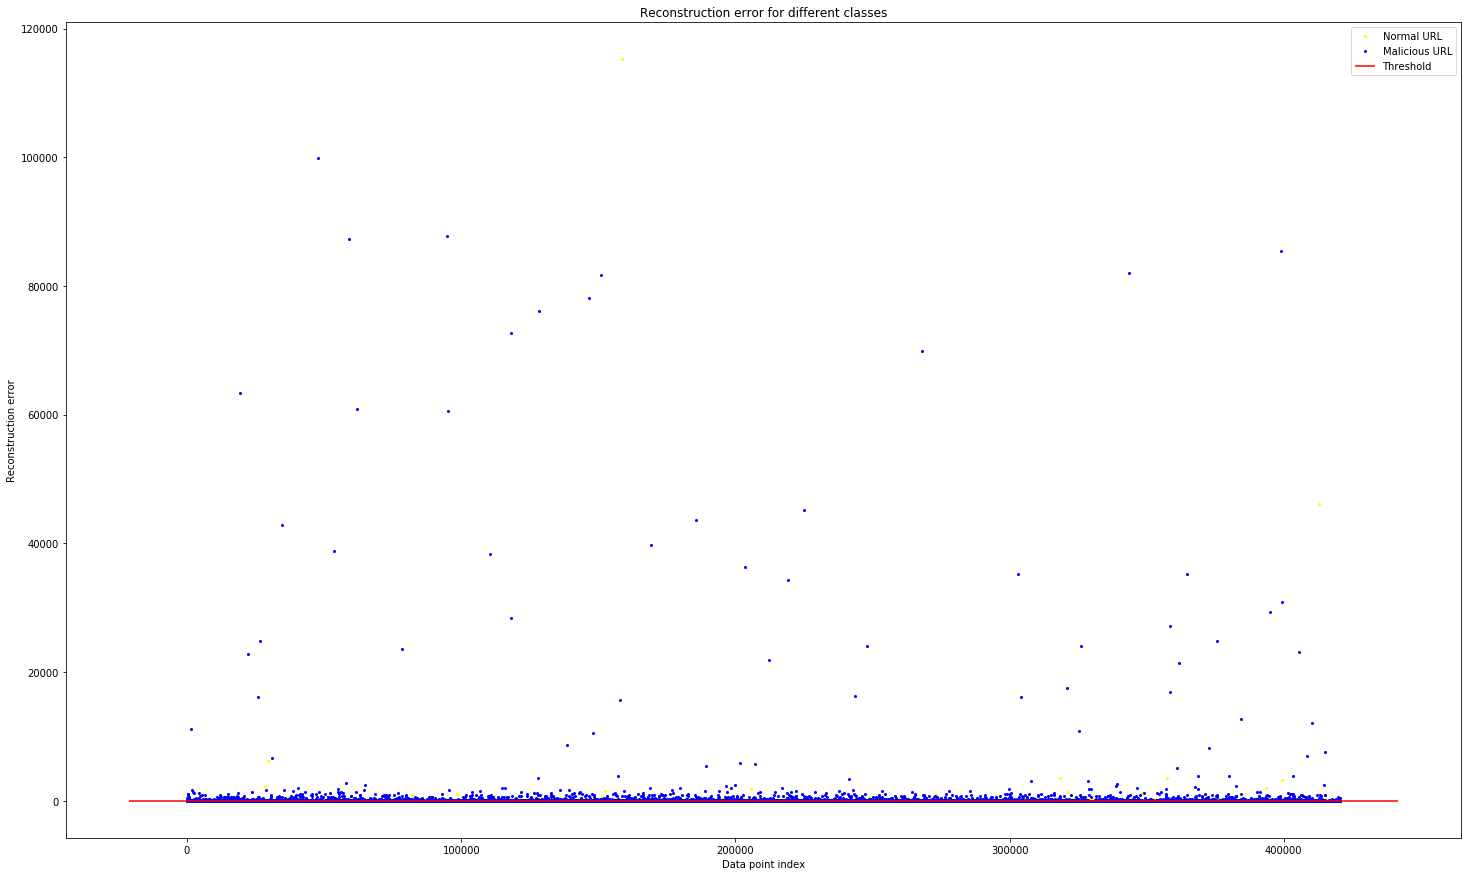

In [23]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(25, 15))
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=2, linestyle='',
            label= "Malicious URL" if name == 1 else "Normal URL", color= 'blue' if name == 1 else 'yellow')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="red", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();